## Load sample data

In [1]:
import json
with open('qm9_sample.json', 'r') as f:
    data = json.load(f)

## Process train_structures and train_targets

In [2]:
from pymatgen import Molecule
from megnet.utils.molecule import MEGNetMolecule

qm9_ids = list(data.keys())

molecules = [Molecule.from_dict(data[i]['molecule']) for i in qm9_ids]  # this gives a list of pymatgen Molecule

structures = [MEGNetMolecule.from_pymatgen(i) for i in molecules]  # Wrap Molecule to MEGNetMolecule
targets = [data[i]['property']['U0'] for i in qm9_ids]  # We are training U0 here


## Data splits

In reality, use train-val-test splits. Validation split can be used to select hyperparameters (e.g., epochs)

In [3]:
train_structures = structures[:80]
test_structures = structures[80:]
train_targets = targets[:80]
test_targets = targets[80:]

## Construct megnet models

In [4]:
from megnet.models import MEGNetModel
from megnet.data.graph import GaussianDistance
from megnet.data.crystal import CrystalGraph
from megnet.utils.preprocessing import StandardScaler
import numpy as np

Using TensorFlow backend.


In [5]:
gc = CrystalGraph(bond_converter=GaussianDistance(np.linspace(0, 5, 100), 0.5), cutoff=4)
model = MEGNetModel(100, 2, graph_converter=gc)

### Scale targets to train per atom quantity 

In [6]:
INTENSIVE = False # U0 is an extensive quantity
scaler = StandardScaler.from_training_data(train_structures, train_targets, is_intensive=INTENSIVE)
model.target_scaler = scaler

## Train the model!

In [7]:
model.train(train_structures, train_targets, epochs=10, verbose=2)  # In reality, use epochs>1000

/Users/chenchi/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
 - 8s - loss: 0.9995
Epoch 2/10
 - 1s - loss: 0.9984
Epoch 3/10
 - 1s - loss: 0.9967
Epoch 4/10
 - 1s - loss: 0.9950
Epoch 5/10
 - 1s - loss: 0.9932
Epoch 6/10
 - 1s - loss: 0.9908
Epoch 7/10
 - 1s - loss: 0.9878
Epoch 8/10
 - 1s - loss: 0.9844
Epoch 9/10
 - 0s - loss: 0.9800
Epoch 10/10
 - 1s - loss: 0.9742


## Predict test data

In [8]:
predicted_tests = []
for i in test_structures:
    predicted_tests.append(model.predict_structure(i).ravel()[0])

Text(0, 0.5, 'Predicted $U_0$ (eV)')

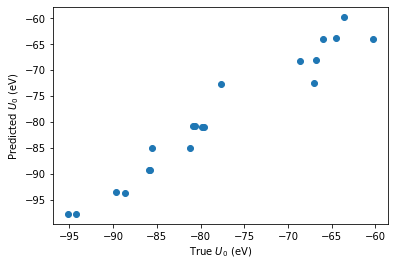

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(test_targets, predicted_tests, 'o')
plt.xlabel('True $U_0$ (eV)')
plt.ylabel('Predicted $U_0$ (eV)')

Results seem to be good considering that we are using 80 data points to train the model!